# 🏀 Predicción NBA 2026 — Notebook 01: Descarga y exploración inicial

En este notebook:

1. Descargamos los logs de partidos a nivel equipo desde la API oficial de la NBA (`nba_api`).
2. Construimos:
   - `df_team_games`: dataset a nivel EQUIPO–PARTIDO.
   - `df_games`: dataset a nivel PARTIDO (HOME vs AWAY).
3. Guardamos los datasets en la carpeta `data/`.
4. Realizamos una exploración inicial muy básica.


In [1]:
import pandas as pd

from src.data_fetch import (
    get_current_season_team_logs,
    build_team_level_dataset,
    build_game_level_dataset,
)

pd.set_option("display.max_columns", 60)


## 📥 Cargar datos oficiales desde la API de la NBA

Usaremos `get_current_season_team_logs()` para obtener todos los registros TEAM-GAME
y luego `build_game_level_dataset()` para pasarlo a nivel PARTIDO.


In [2]:
# 1. Descarga de logs crudos desde la API
df_logs = get_current_season_team_logs()
print(df_logs.shape)
df_logs.head()


(382, 13)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,PTS,FGA,FTA,OREB,TOV
0,22025,1610612745,HOU,Houston Rockets,0022500001,2025-10-21,HOU @ OKC,L,124,97,31,16,25
1,22025,1610612744,GSW,Golden State Warriors,0022500002,2025-10-21,GSW @ LAL,W,119,78,29,9,19
2,22025,1610612747,LAL,Los Angeles Lakers,0022500002,2025-10-21,LAL vs. GSW,L,109,77,28,7,20
3,22025,1610612760,OKC,Oklahoma City Thunder,0022500001,2025-10-21,OKC vs. HOU,W,125,104,25,11,12
4,22025,1610612737,ATL,Atlanta Hawks,0022500082,2025-10-22,ATL vs. TOR,L,118,90,37,8,16


In [3]:
# 2. Construcción del dataset a nivel equipo-partido
df_team_games = build_team_level_dataset(df_logs)
print(df_team_games.shape)
df_team_games.head()


(382, 16)


,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,IS_HOME,POINTS_FOR,POINTS_AGAINST,WIN,MARGIN,FGA,FTA,OREB,TOV,MATCHUP,SEASON_ID
1,0022500082,2025-10-22,1610612737,ATL,Atlanta Hawks,1,118,138,0,-20,90,37,8,16,ATL vs. TOR,22025
3,0022500090,2025-10-24,1610612737,ATL,Atlanta Hawks,0,111,107,1,4,85,28,9,16,ATL @ ORL,22025
5,0022500101,2025-10-25,1610612737,ATL,Atlanta Hawks,1,100,117,0,-17,85,21,15,17,ATL vs. OKC,22025
7,0022500115,2025-10-27,1610612737,ATL,Atlanta Hawks,0,123,128,0,-5,98,20,8,6,ATL @ CHI,22025
9,0022500130,2025-10-29,1610612737,ATL,Atlanta Hawks,0,117,112,1,5,93,22,13,8,ATL @ BKN,22025


In [4]:
# 3. Construcción del dataset a nivel partido (HOME vs AWAY)
df_games = build_game_level_dataset(df_team_games)
print(df_games.shape)
df_games.head()


(190, 17)


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_ABBR,HOME_TEAM_NAME,HOME_PTS,HOME_PA,HOME_MARGIN,AWAY_TEAM_ID,AWAY_TEAM_ABBR,AWAY_TEAM_NAME,AWAY_PTS,AWAY_PA,AWAY_MARGIN,HOME_WIN,MARGIN_HOME,TOTAL_POINTS
0,0022500002,2025-10-21,1610612747,LAL,Los Angeles Lakers,109,119,-10,1610612744,GSW,Golden State Warriors,119,109,10,0,-10,228
1,0022500001,2025-10-21,1610612760,OKC,Oklahoma City Thunder,125,124,1,1610612745,HOU,Houston Rockets,124,125,-1,1,1,249
2,0022500082,2025-10-22,1610612737,ATL,Atlanta Hawks,118,138,-20,1610612761,TOR,Toronto Raptors,138,118,20,0,-20,256
3,0022500084,2025-10-22,1610612741,CHI,Chicago Bulls,115,111,4,1610612765,DET,Detroit Pistons,111,115,-4,1,4,226
4,0022500086,2025-10-22,1610612749,MIL,Milwaukee Bucks,133,120,13,1610612764,WAS,Washington Wizards,120,133,-13,1,13,253


## 🔍 1. Exploración básica del dataset `df_games`

En esta sección revisamos:

- Estructura del dataframe (`info()`)
- Número de registros y columnas
- Presencia de valores nulos
- Posibles filas duplicadas


In [5]:
df_games["HOME_WIN"].mean()


np.float64(0.5684210526315789)

In [7]:
df_games[["MARGIN_HOME", "TOTAL_POINTS"]].describe()


,MARGIN_HOME,TOTAL_POINTS
count,190.000000,190.000000
mean,2.610526,233.400000
std,15.642700,19.404576
min,-33.000000,158.000000
25%,-7.750000,221.000000
50%,4.000000,232.000000
75%,13.000000,246.000000
max,40.000000,281.000000


### 1.1 Valores nulos y filas duplicadas


In [6]:
# Conteo de nulos por columna
df_games.isna().sum()


GAME_ID           0
GAME_DATE         0
HOME_TEAM_ID      0
HOME_TEAM_ABBR    0
HOME_TEAM_NAME    0
HOME_PTS          0
HOME_PA           0
HOME_MARGIN       0
AWAY_TEAM_ID      0
AWAY_TEAM_ABBR    0
AWAY_TEAM_NAME    0
AWAY_PTS          0
AWAY_PA           0
AWAY_MARGIN       0
HOME_WIN          0
MARGIN_HOME       0
TOTAL_POINTS      0
dtype: int64

In [6]:
# Número de filas completamente duplicadas
df_games.duplicated().sum()


np.int64(0)

## 📊 2. Estadística descriptiva básica

Analizamos:

- Puntos del equipo local (`HOME_PTS`)
- Puntos del equipo visitante (`AWAY_PTS`)
- Margen de victoria del local (`MARGIN_HOME`)


In [7]:
df_games[["HOME_PTS", "AWAY_PTS", "MARGIN_HOME"]].describe()


,HOME_PTS,AWAY_PTS,MARGIN_HOME
count,12.000000,12.000000,12.000000
mean,120.416667,119.416667,1.000000
std,11.942729,7.925314,15.614678
min,92.000000,108.000000,-33.000000
25%,115.750000,115.500000,-3.250000
50%,122.000000,119.500000,4.000000
75%,128.250000,122.500000,9.250000
max,136.000000,138.000000,21.000000


## 📈 3. Distribuciones de puntos y margen

Visualizamos la distribución de:

- Puntos del local
- Puntos del visitante
- Margen del local

Esto nos ayuda a:

- Detectar valores atípicos
- Ver el rango típico de anotación
- Ver si el margen está centrado alrededor de 0 (partidos parejos)


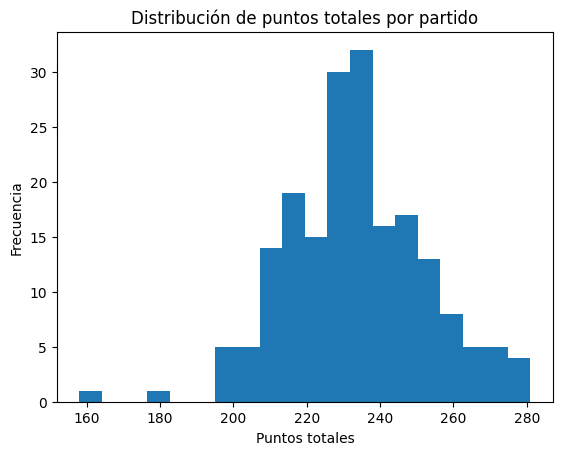

In [8]:
import matplotlib.pyplot as plt

plt.hist(df_games["TOTAL_POINTS"], bins=20)
plt.xlabel("Puntos totales")
plt.ylabel("Frecuencia")
plt.title("Distribución de puntos totales por partido")
plt.show()


## 💾 6. Guardar dataset procesado

Guardamos el dataset resultante en la carpeta `data/processed/` para reutilizarlo
en los siguientes notebooks, sin necesidad de llamar nuevamente al API.


In [9]:
# Guardamos para reutilizar en otros notebooks
df_logs.to_csv("../data/raw/team_logs_2025_26.csv", index=False)
df_team_games.to_csv("../data/processed/team_games_2025_26.csv", index=False)
df_games.to_csv("../data/processed/games_2025_26_basic.csv", index=False)


# ✅ Resumen del Notebook 01 — Exploración Inicial

En este notebook:

- Descargamos los datos oficiales de la temporada actual desde `stats.nba.com` usando `nba_api`.
- Convertimos el game log a un dataset a nivel **PARTIDO** (HOME vs AWAY en una fila).
- Exploramos:
  - Estructura del dataset (`info()`)
  - Nulos y duplicados
  - Estadísticos descriptivos de puntos y margen

- Guardamos el dataset procesado en `data/processed/games_2025_26_basic.csv`.

